In [13]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import itertools

import warnings
warnings.filterwarnings('ignore')

temp = os.getcwd()
print(f'Current working directory: {temp}')
if '/project1' in temp:
    temp = temp.replace('/project1', '')
    os.chdir(temp)
elif '/project2' in temp:
    temp = temp.replace('/project2', '')
    os.chdir(temp)
    print(f'Switched to: {temp}')

Current working directory: /Users/marco/dev/time-series


In [14]:
data = pd.read_excel('data/QualidadeARO3.xlsx')
data = data.drop(columns='Ihavo')
rng = pd.date_range('1/1/2020 00:00', periods=8784, freq='1H')
data.index = rng

In [9]:
data.shape

(8784, 9)

# 1. Fit SARIMA type model

## (a) initial examination of the data

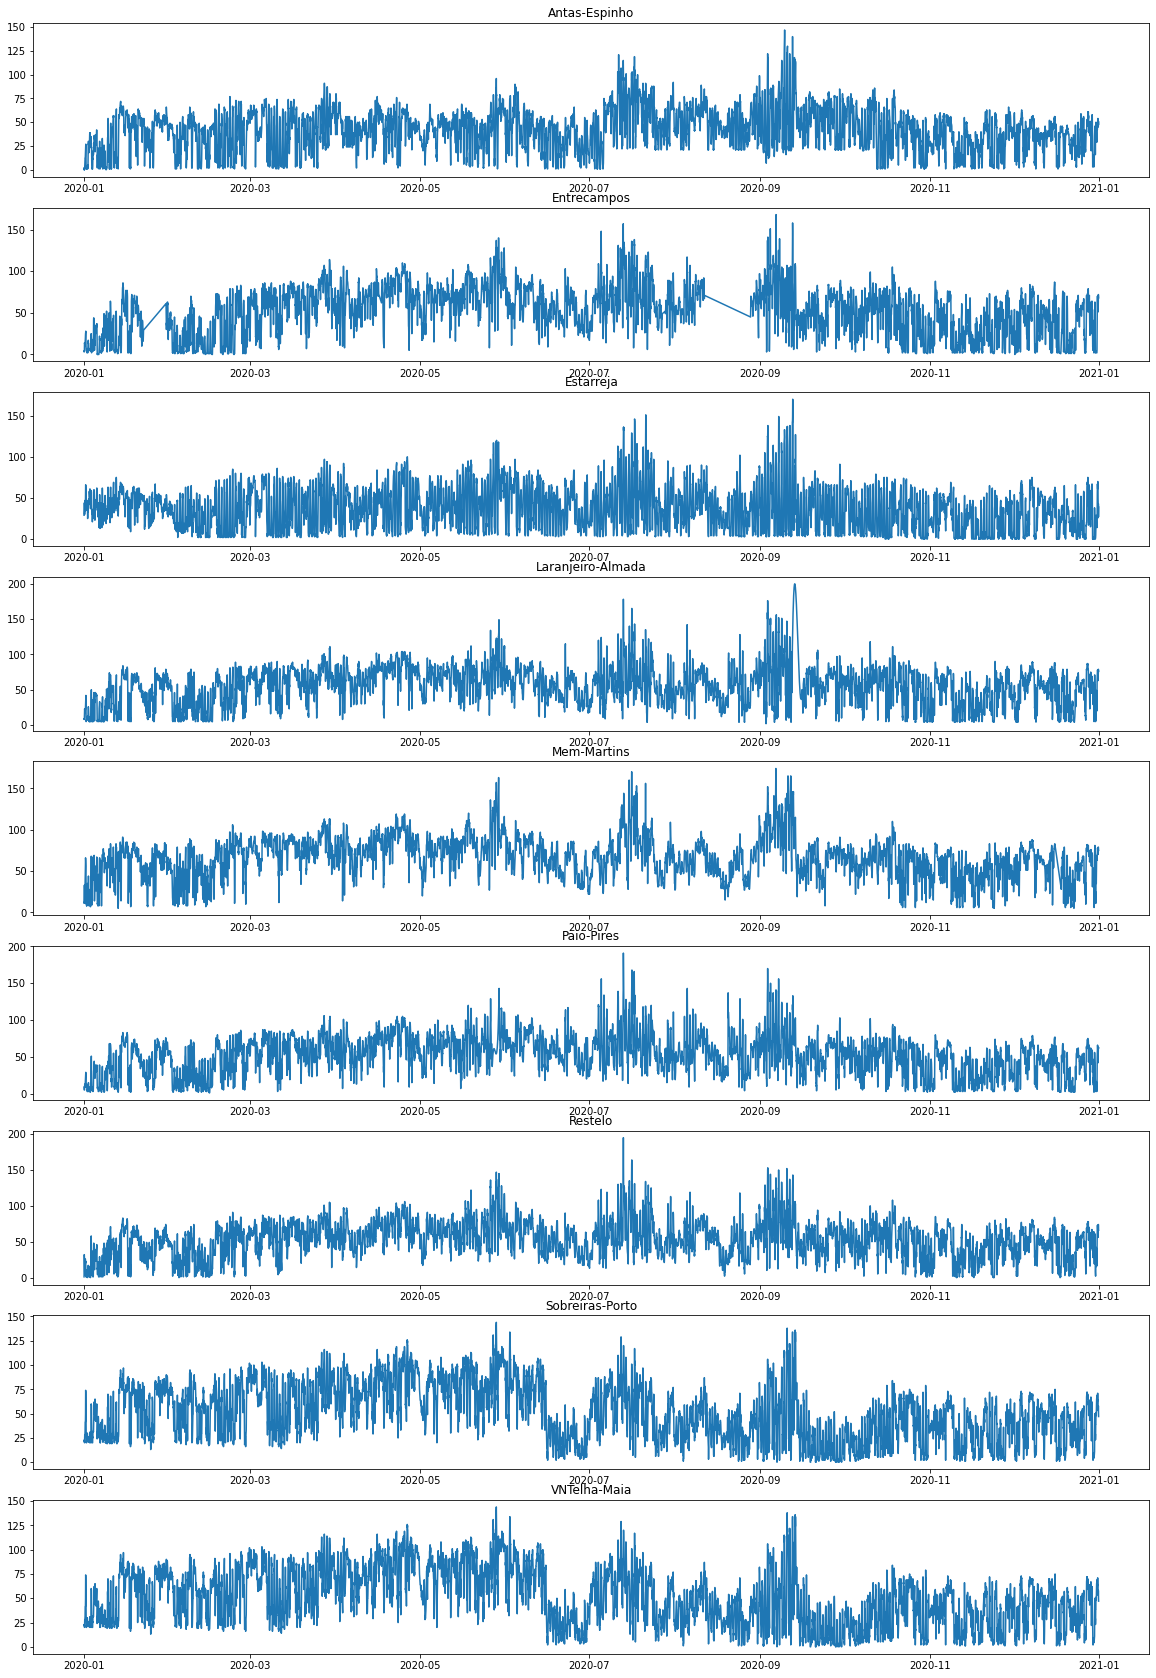

In [15]:
plt.figure(figsize=(20,30))
for idx, o2levels in enumerate(data.columns):
    plt.subplot(9, 1, idx+1)
    plt.plot(data.index, data[o2levels])
    plt.gca().set_title(o2levels)
plt.show()

## (b) transformations if necessary

In [16]:
adf_df = pd.DataFrame(index=data.columns, columns=['ADF_Statistic', 'p_value', 'Stationary'])
sig_level = 0.05

for i in range(0,data.shape[1]):
    adf_tmp = adfuller(data.iloc[:,i])
    adf_df.iloc[i,0] = adf_tmp[0]
    adf_df.iloc[i,1] = adf_tmp[1]
    adf_df.iloc[i,2] = True if adf_tmp[1] < sig_level else False


In [17]:
adf_df.Stationary

Antas-Espinho        True
Entrecampos          True
Estarreja            True
Laranjeiro-Almada    True
Mem-Martins          True
Paio-Pires           True
Restelo              True
Sobreiras-Porto      True
VNTelha-Maia         True
Name: Stationary, dtype: object

we perform the Augmented Dickey-Fuller test to check for the stationarity condition 

our null hypothesis is that the time series is not stationary and the alternative is that it is indeed stationary

when testing with a significance level of 0.05, we see that the p-value for the statistic for all given time series is smaller that our level, thus we can conclude that our time series are stationary and we don't need any further transformations

## (c) initial identification of dependence orders

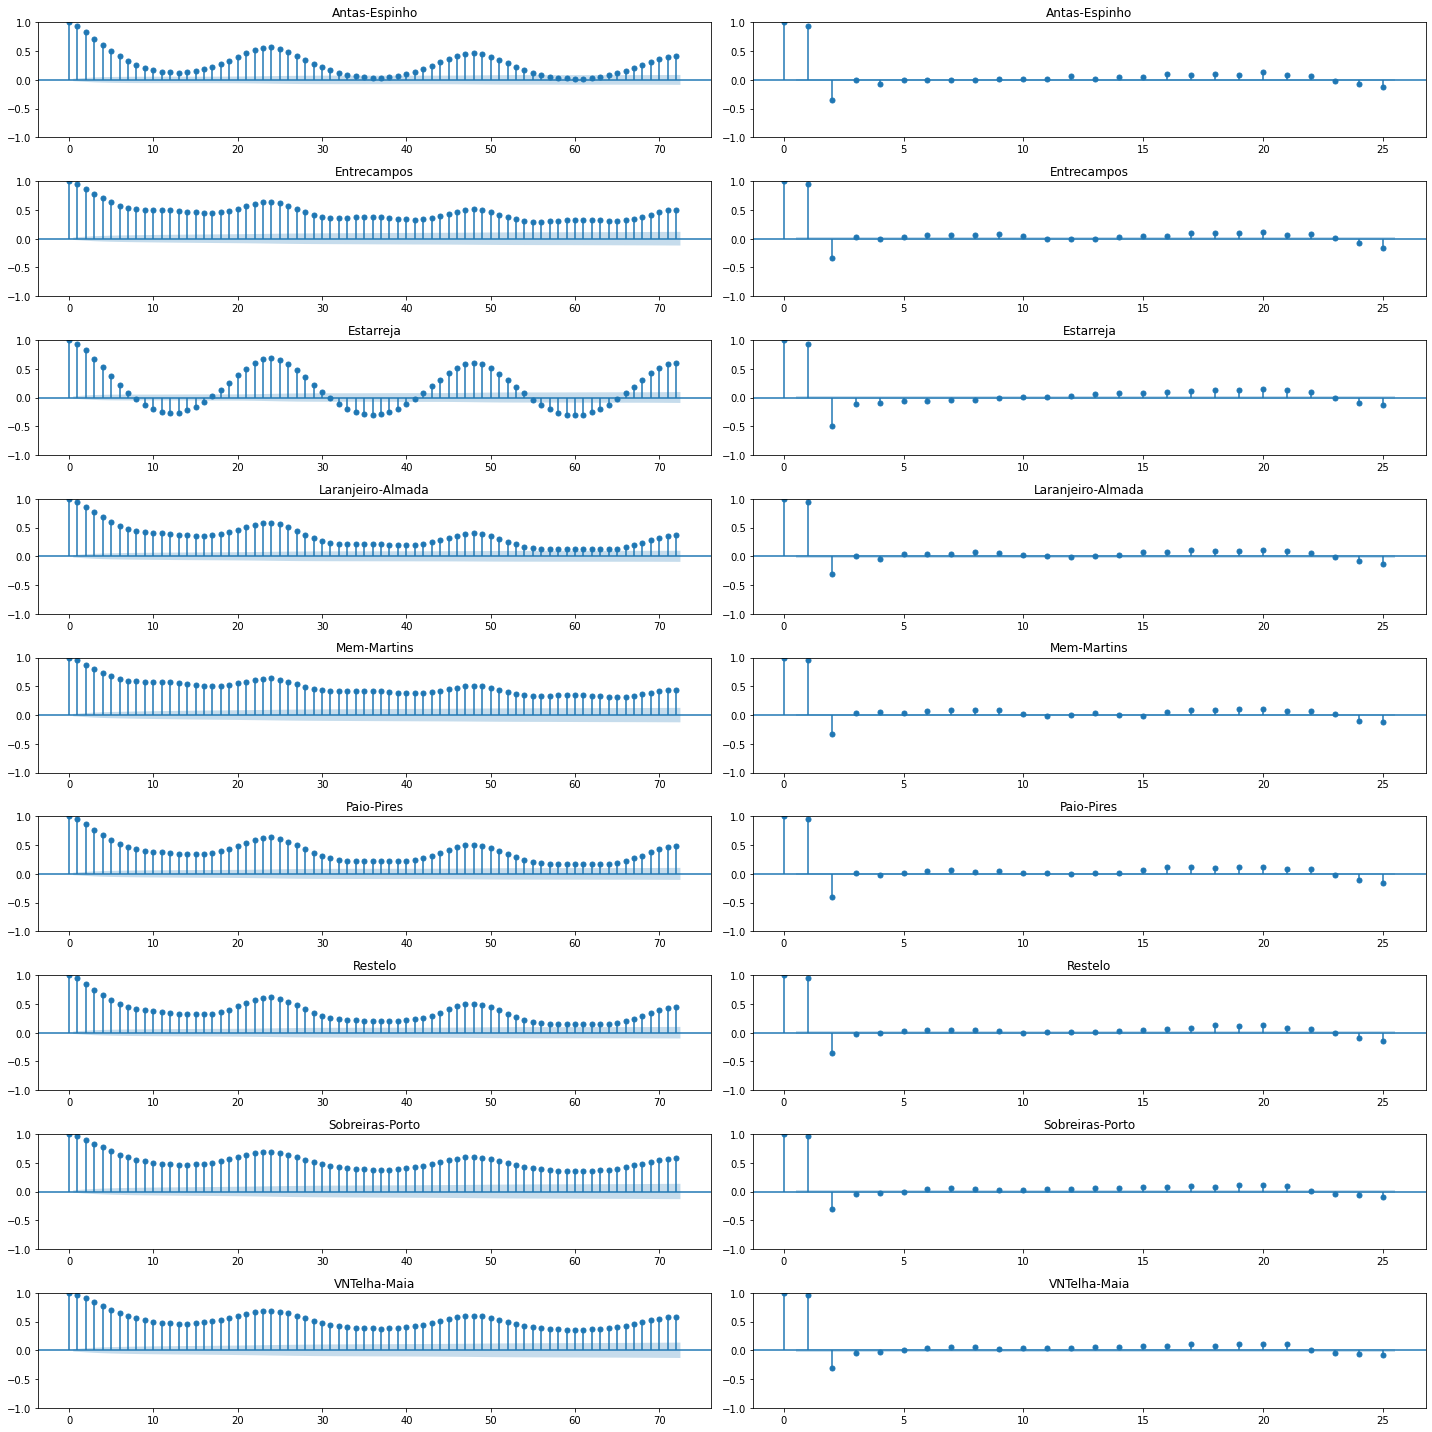

In [18]:
fig = plt.figure(figsize=(20,20))

for idx, o2levels in enumerate(data.columns):
    plot_acf(data[o2levels], lags=72, title=o2levels, ax=plt.subplot(9, 2, idx*2+1))
    plot_pacf(data[o2levels], lags=25, title=o2levels, ax=plt.subplot(9, 2, idx*2+2))

fig.tight_layout()
plt.show()

when having a look at the pacf's of the time series we can see a strong peak at lag 1 which suggests an AR(1) process

when having a look at the acf's of the time series we can see strong peaks at the lags (0,) 24, 48 etc ie seasonality of 24!

'In fact, looking closely, we can see some sinusoidal shape in both ACF and PACF functions. This suggests that both processes are in play' - (https://towardsdatascience.com/advanced-time-series-analysis-with-arma-and-arima-a7d9b589ed6d)

## (d) parameter estimation

as described in (b) we know that our time series are stationary hence there is no trend
since we don't have a trend we know that d=0
the sinus shape of both the acf and pacf suggests that both AR and MA are in play
further we already established that we have S=24
thus we are left with four free parameters: p, q, P, Q

In [20]:
endog = data.Entrecampos
p_list = list(range(1,2))
q_list = list(range(1,2))
P_list = list(range(1,2))
Q_list = list(range(1,2))
model_dict = {}

for p,q,P,Q in itertools.product(p_list, q_list, P_list, Q_list):
    p,q,P,Q = 1,1,1,1
    #print(f'{p},{q},{P},{Q}')
    model_fit = SARIMAX(endog, order=(p,0,q), seasonal_order=(P,0,Q, 24)).fit(disp=True) #normal fitten? in towardsdatascience .fit(disp=-1)
    print(model_fit.summary)
    
    model_dict[f'{p},{q},{P},{Q}'] = (model_fit.bic, model_fit.aic, model_fit)
    print(f'{p},{q},{P},{Q}: {model_fit.bic},{model_fit.aic}')


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53827D+00    |proj g|=  2.02369D-01


 This problem is unconstrained.



At iterate    1    f=  3.47984D+00    |proj g|=  8.78327D-02

At iterate    2    f=  3.46576D+00    |proj g|=  3.52000D-02

At iterate    3    f=  3.46049D+00    |proj g|=  1.56109D-02

At iterate    4    f=  3.45870D+00    |proj g|=  1.33803D-02

At iterate    5    f=  3.45546D+00    |proj g|=  1.13559D-02

At iterate    6    f=  3.45260D+00    |proj g|=  8.67168D-03

At iterate    7    f=  3.45081D+00    |proj g|=  8.56374D-03

At iterate    8    f=  3.44672D+00    |proj g|=  4.72624D-03

At iterate    9    f=  3.44064D+00    |proj g|=  6.35039D-03

At iterate   10    f=  3.43467D+00    |proj g|=  1.86348D-02

At iterate   11    f=  3.43337D+00    |proj g|=  2.31587D-02

At iterate   12    f=  3.43258D+00    |proj g|=  1.11324D-02

At iterate   13    f=  3.43239D+00    |proj g|=  6.46491D-03

At iterate   14    f=  3.43218D+00    |proj g|=  6.04791D-03

At iterate   15    f=  3.43122D+00    |proj g|=  1.01617D-02

At iterate   16    f=  3.43084D+00    |proj g|=  8.54174D-03

At iter

## (e) residual diagnostics and model choice